Решить задачу регрессии.
Получить максимальную метрику качества (R2, RMSE).

Введение
Целью данной задачи является прогнозирование суммы пятничных распродаж в магазинах сети Walmart с помощью построения регрессионных моделей и их анализа.
Набор данных состоит из исторических данных, которые охватывают продажи с 2010-02-05 по 2012-11-01, предствленных в файле Walmart.csv

#Использовать приплайны.
#Выполнить поиск лучших параметров / *hyperopt / **optuna
#Кроссвалидация / различные типы проверок.
#Сохранить и загрузить модель. 
#H20 (если получиться)

+ phik

Откроем датасет

In [29]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import  matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures  
from sklearn.metrics import r2_score  
from sklearn.linear_model import BayesianRidge  
from sklearn.linear_model import ElasticNet  
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import pickle
from hyperopt import fmin, tpe,rand, space_eval,hp

pd.set_option("display.max_columns", 15)
np.set_printoptions(edgeitems=20, linewidth=170000,
    formatter=dict(float=lambda x: "%.5g" % x))

df = pd.read_csv("Walmart.csv",encoding='Windows-1251' ,on_bad_lines='skip',
                    #index_col='client_id' ,
                    usecols=[0,1,2,3,4, 5,6,7]
                    )
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


Заменим календарные даты на порядковый день года (графа Date). Это позволит выявить зависимости между сезонами:

In [33]:
age_column = df['Date']
def day_number(x):
    return datetime.strptime(x, '%d-%m-%Y').timetuple().tm_yday
new_age_column = age_column.apply(day_number)
df['Date'] = new_age_column
print(df)

      Store  Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0         1    36    1643690.90             0        42.31       2.572   
1         1    43    1641957.44             1        38.51       2.548   
2         1    50    1611968.17             0        39.93       2.514   
3         1    57    1409727.59             0        46.63       2.561   
4         1    64    1554806.68             0        46.50       2.625   
...     ...   ...           ...           ...          ...         ...   
6430     45   272     713173.95             0        64.88       3.997   
6431     45   279     733455.07             0        64.89       3.985   
6432     45   286     734464.36             0        54.47       4.000   
6433     45   293     718125.53             0        56.47       3.969   
6434     45   300     760281.43             0        58.85       3.882   

             CPI  Unemployment  
0     211.096358         8.106  
1     211.242170         8.106  
2     211.28

Применим разные виды регрессии для прогнозирования:
Применим cross_val_score

In [34]:
y = df['Weekly_Sales']
X = df[['Store','Date','Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

logreg = LinearRegression()
logreg.fit(X_train,y_train)
y_pred_logreg = logreg.predict(X_test)
print(f"The r2 score of the model LOGREG is: {r2_score(y_test, y_pred_logreg)}")  

scores = cross_val_score(logreg, X, y, cv=5)
print("Значения правильности перекрестной проверки: {}".format(scores))

ridge = Ridge(alpha=1.0)
ridge.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)
print(f"The r2 score of the model Ridge is: {r2_score(y_test, y_pred_ridge)}")  

b_ringe = BayesianRidge()  
b_ringe.fit(X_train,y_train)
y_pred_bridge = b_ringe.predict(X_test)
print(f"The r2 score of the model BayesianRidge is: {r2_score(y_test, y_pred_bridge)}")  

el = ElasticNet(alpha = 0.5)  
el.fit(X_train, y_train)    
y_pred_el = el.predict(X_test)
print(f"The r2 score of the model ElasticNet is: {r2_score(y_test, y_pred_el)}")  
# Printing the coefficients of the model  
print("el coefficient ",el.coef_)    
# Printing the intercept of the best fitting line  
print("el intercept ",el.intercept_)  

The r2 score of the model LOGREG is: 0.13068551918885463
Значения правильности перекрестной проверки: [-0.51885 -0.010369 -0.24609 -0.15105 -0.43614]
The r2 score of the model Ridge is: 0.13068314717827767
The r2 score of the model BayesianRidge is: 0.12953884349061529
The r2 score of the model ElasticNet is: 0.12986289429511466
el coefficient  [-15445 582.08 4392.2 -2084.8 9464.5 -2160 -16949]
el intercept  1894972.9692978945


Лучшие показатели, хоть и слабые получаются у логситической регрессии, и Ridge

Далее визуализируем данные по столбцам:

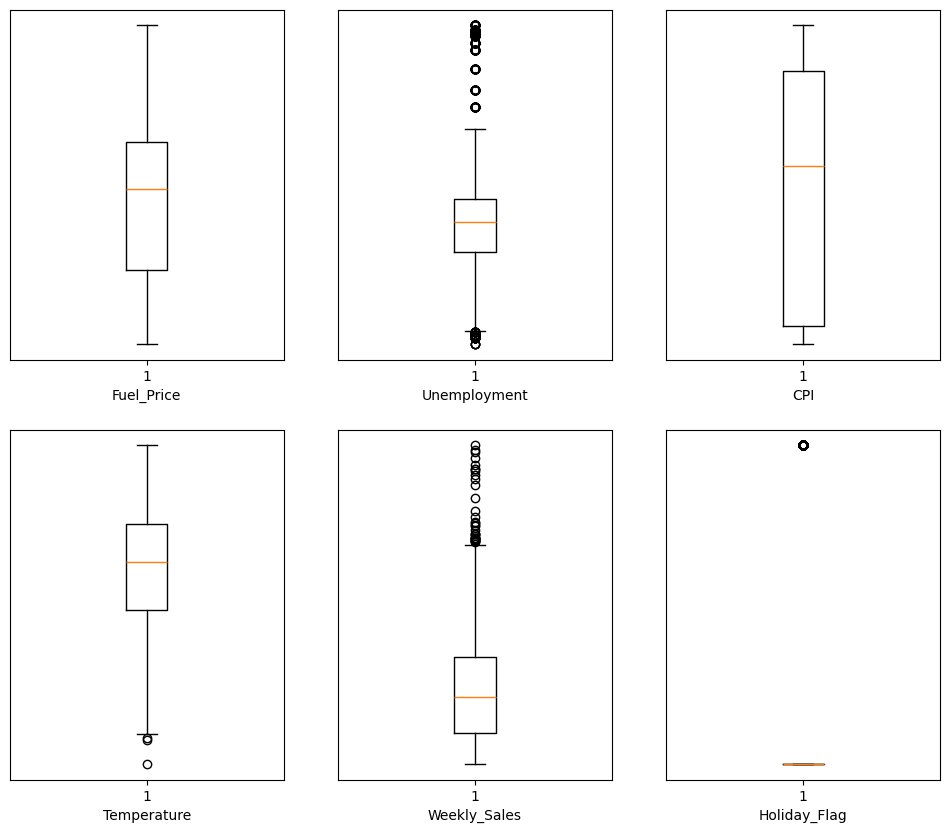

In [22]:
columns = {'Temperature','Holiday_Flag', 'Fuel_Price','CPI','Unemployment','Weekly_Sales'}
fig, axes = plt.subplots(2, 3, figsize=(12, 10),  subplot_kw={'xticks':(), 'yticks': ()})

for ax,column in zip (axes.ravel(), columns):
    ax.boxplot(df[column]) 
    ax.set(xlabel=column) 

plt.show()

Выбросы есть, но удалять не будем.

Оценим данные на наличие зависимости. Сгруппируем по номеру магазина  и найдем средние недельные распродажи:

In [36]:
df_view_of_data = df[["Store","Weekly_Sales"]]
df_view_of_data2 = df_view_of_data.groupby(by = "Store",dropna=True).mean()
print(df_view_of_data2)

       Weekly_Sales
Store              
1      1.555264e+06
2      1.925751e+06
3      4.027044e+05
4      2.094713e+06
5      3.180118e+05
6      1.564728e+06
7      5.706173e+05
8      9.087495e+05
9      5.439806e+05
10     1.899425e+06
11     1.356383e+06
12     1.009002e+06
13     2.003620e+06
14     2.020978e+06
15     6.233125e+05
16     5.192477e+05
17     8.935814e+05
18     1.084718e+06
19     1.444999e+06
20     2.107677e+06
21     7.560691e+05
22     1.028501e+06
23     1.389864e+06
24     1.356755e+06
25     7.067215e+05
26     1.002912e+06
27     1.775216e+06
28     1.323522e+06
29     5.394514e+05
30     4.385796e+05
31     1.395901e+06
32     1.166568e+06
33     2.598617e+05
34     9.667816e+05
35     9.197250e+05
36     3.735120e+05
37     5.189003e+05
38     3.857317e+05
39     1.450668e+06
40     9.641280e+05
41     1.268125e+06
42     5.564039e+05
43     6.333247e+05
44     3.027489e+05
45     7.859814e+05


Далее создадим модель, которая просто выдает средние продажи по текущему магазину:

In [24]:
#замена целевой переменной на средние значения по магазину и подсчет разницы: 
df_mean = df
df_mean['Weekly_Sales_Mean'] = df_mean.groupby(['Store'])['Weekly_Sales'].transform('mean') 
print(df.head())
print(f"The r2 score of the model MEAN is: {r2_score(df_mean['Weekly_Sales'],df_mean['Weekly_Sales_Mean'] )}")  

   Store  Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1    36    1643690.90             0        42.31       2.572   
1      1    43    1641957.44             1        38.51       2.548   
2      1    50    1611968.17             0        39.93       2.514   
3      1    57    1409727.59             0        46.63       2.561   
4      1    64    1554806.68             0        46.50       2.625   

          CPI  Unemployment  Weekly_Sales_Mean  
0  211.096358         8.106       1.555264e+06  
1  211.242170         8.106       1.555264e+06  
2  211.289143         8.106       1.555264e+06  
3  211.319643         8.106       1.555264e+06  
4  211.350143         8.106       1.555264e+06  
The r2 score of the model MEAN is: 0.917415373473202


Такая модель имеет довольно высокий результат, почти 92 процента.

Далее построим матрицу корреляции:

interval columns not set, guessing: ['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales_Mean']


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales_Mean
Store,1.000000,0.000000,0.668894,0.000000,0.376575,0.325780,0.578986,0.689064,0.868031
Date,0.000000,1.000000,0.291504,0.452241,0.735466,0.602953,0.077032,0.223966,0.000000
Weekly_Sales,0.668894,0.291504,1.000000,0.112003,0.256241,0.192382,0.354949,0.393642,0.918581
Holiday_Flag,0.000000,0.452241,0.112003,1.000000,0.235493,0.169441,0.000000,0.000000,0.000000
Temperature,0.376575,0.735466,0.256241,0.235493,1.000000,0.495514,0.335435,0.287975,0.303235
Fuel_Price,0.325780,0.602953,0.192382,0.169441,0.495514,1.000000,0.493494,0.511182,0.298062
CPI,0.578986,0.077032,0.354949,0.000000,0.335435,0.493494,1.000000,0.552244,0.564278
Unemployment,0.689064,0.223966,0.393642,0.000000,0.287975,0.511182,0.552244,1.000000,0.616340
Weekly_Sales_Mean,0.868031,0.000000,0.918581,0.000000,0.303235,0.298062,0.564278,0.616340,1.000000


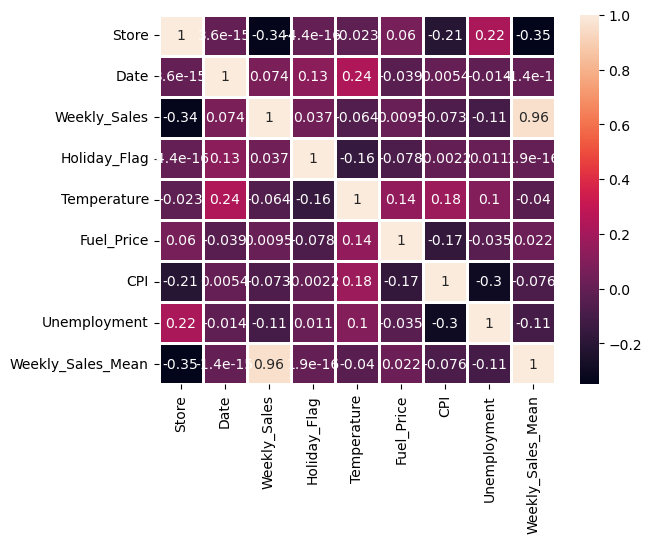

In [25]:
!pip install phik
import phik 
from phik import resources, report
df_head = df_mean.head(30)
corr_matrix = df_mean.corr()
sb.heatmap(corr_matrix,annot=True, linewidths=1)
df_mean.phik_matrix()

Мы видим, что матрица корреляции показывает наивысшую корреляцию со средними продажами по магазину.

Далее создадим пайплайн и сделаем еще одно предсказание.

In [38]:
# Создадим пайплайн для подстановки плассификаторов:
pipe = Pipeline(
    steps=[
           ("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler()),
           ("regressor", LinearRegression())]
            #Ridge()
)

pipe.fit(X_train,y_train)
y_predict = pipe.predict(X_test)
print(f"The r2 score of the model Pipeline LinearRegression is: {r2_score(y_test,y_predict)}")  

# Проверим, увеличит ли показатели разбиение по магазину с помощью ONEHOTENCODER:
df_pandas_encoded = pd.get_dummies(df, columns=['Store'], drop_first=True,dtype = int)
#print(df_pandas_encoded)
pipe.fit(X_train,y_train)
y_predict = pipe.predict(X_test)
print(f"The r2 score of the model Regression_over_ONEHOTENCODER is: {r2_score(y_test,y_predict)}")  

# Далее сохраним и загрузим модель в PICKLE
filename = 'LinearRegression.pkl'
pickle.dump(pipe, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print("Model score after save model and load from the disk", result)


The r2 score of the model Pipeline LinearRegression is: 0.13068551918885485
The r2 score of the model Regression_over_ONEHOTENCODER is: 0.13068551918885485
Model score after save model and load from the disk 0.13068551918885485


ONEHOTENCODER не помог, показатели не увеличились.

Подберем параметры метода BayesianRidge при помощи hyperopt

In [ ]:
!pip install hyperopt

#зададим пространство поиска
space = [hp.uniform('max_iter', 200,400), hp.uniform('tol', 0.0005, 0.003),hp.uniform('alpha_1', 1e-07, 4e-06) ] 

#укажем objective-функцию
def f(args):
    b_ringe = BayesianRidge()  
    b_ringe.fit(X_train,y_train)
    y_pred_bridge = b_ringe.predict(X_test)
    return -r2_score(y_test, y_pred_bridge)      

best = fmin(f, space, algo = tpe.suggest, max_evals=100)
print ('TPE result: ', best)

best = fmin(f, space, algo = rand.suggest, max_evals=100)
print ('random result: ', best)

100%|██████████| 100/100 [00:00<00:00, 139.06trial/s, best loss: -0.12953884349061529]
TPE result:  {'alpha_1': 3.409194904795144e-06, 'max_iter': 356.0210305789584, 'tol': 0.0017043310410841952}
100%|██████████| 100/100 [00:00<00:00, 234.97trial/s, best loss: -0.12953884349061529]
random result:  {'alpha_1': 3.3385506914932502e-06, 'max_iter': 222.5767439824565, 'tol': 0.0013128685309987936}


Нашли 2 локальных максиммума. Показатели одинаковые, а параметры разные.